In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [2]:
train_file_path = "../data/diabetes_prediction_dataset.csv"
df = pd.read_csv(train_file_path)

# fix some of the data issues
df["smoking_history"] = df["smoking_history"].replace("No Info", "unknown")
df["smoking_history"] = df["smoking_history"].replace("not current", "former")
df["smoking_history"] = df["smoking_history"].replace("ever", "former")

sh_hots = pd.get_dummies(df["smoking_history"], prefix="sh", dtype=int)
df = pd.concat([df, sh_hots], axis=1)
df = df.drop(["smoking_history"], axis=1)

df["gender"] = df["gender"].replace("Male", "male")
df["gender"] = df["gender"].replace("Female", "female")
df["gender"] = df["gender"].replace("Other", "other")

sh_hots = pd.get_dummies(df["gender"], prefix="gender", dtype=int)
df = pd.concat([df, sh_hots], axis=1)
df = df.drop(["gender"], axis=1)

df["age"] = (df["age"] - df["age"].mean()) / df["age"].std()
df["bmi"] = (df["bmi"] - df["bmi"].mean()) / df["bmi"].std()
df["HbA1c_level"] = (df["HbA1c_level"] - df["HbA1c_level"].mean()) / df["HbA1c_level"].std()
df["blood_glucose_level"] = (df["blood_glucose_level"] - df["blood_glucose_level"].mean()) / df["blood_glucose_level"].std()

y = df["diabetes"].to_numpy().reshape(-1, 1)
X = df.drop(["diabetes"], axis=1).to_numpy()

In [3]:
# # randomly split the data into training, cross validation and test sets
random_state = 42

X_train, X_blind, y_train, y_blind = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

X_test, X_cv, y_test, y_cv = train_test_split(
    X_blind, y_blind, test_size=0.5, random_state=random_state)

# oversample the training data
# sm = SMOTE(random_state=random_state)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# y_train = y_train.reshape(-1, 1)

print(f'tf.__version__={tf.__version__}')
print(f'X.shape={X.shape}')
print(f'X_train.shape={X_train.shape}')
print(f'X_cv.shape={X_cv.shape}')
print(f'X_test.shape={X_test.shape}')
print(f'y.shape={y.shape}')
print(f'y max={np.max(y)} y min={np.min(y)}')

df.head()

tf.__version__=2.16.1
X.shape=(100000, 13)
X_train.shape=(80000, 13)
X_cv.shape=(10000, 13)
X_test.shape=(10000, 13)
y.shape=(100000, 1)
y max=1 y min=0


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,sh_current,sh_former,sh_never,sh_unknown,gender_female,gender_male,gender_other
0,1.692695,0,1,-0.321054,1.001701,0.047704,0,0,0,1,0,1,0,0
1,0.538004,0,0,-0.000116,1.001701,-1.426203,0,0,0,0,1,1,0,0
2,-0.616688,0,0,-0.000116,0.161107,0.489876,0,0,0,1,0,0,1,0
3,-0.261398,0,0,-0.583229,-0.492688,0.416181,0,1,0,0,0,1,0,0
4,1.515050,1,1,-1.081965,-0.679486,0.416181,0,1,0,0,0,0,1,0


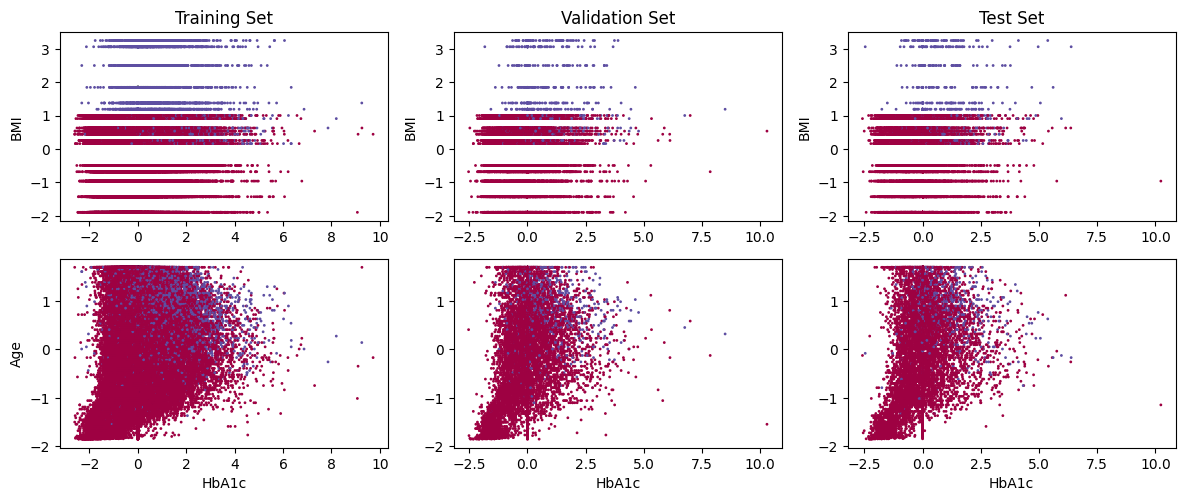

In [4]:
plt.figure(figsize=(8 * 1.8, 3 * 1.8))

plt.subplot(2, 3, 1)
plt.scatter(X_train[:, 3], X_train[:, 4], c=y_train, s=1, cmap=plt.cm.Spectral)
plt.title('Training Set')
plt.ylabel('BMI')

plt.subplot(2, 3, 2)
plt.scatter(X_cv[:, 3], X_cv[:, 4], c=y_cv, s=1, cmap=plt.cm.Spectral)
plt.title('Validation Set')
plt.ylabel('BMI')

plt.subplot(2, 3, 3)
plt.scatter(X_test[:, 3], X_test[:, 4], c=y_test, s=1, cmap=plt.cm.Spectral)
plt.title('Test Set')
plt.ylabel('BMI')

## Second row
plt.subplot(2, 3, 4)
plt.scatter(X_train[:, 3], X_train[:, 0], c=y_train, s=1, cmap=plt.cm.Spectral)
plt.xlabel('HbA1c')
plt.ylabel('Age')

plt.subplot(2, 3, 5)
plt.scatter(X_cv[:, 3], X_cv[:, 0], c=y_cv, s=1, cmap=plt.cm.Spectral)
plt.xlabel('HbA1c')

plt.subplot(2, 3, 6)
plt.scatter(X_test[:, 3], X_test[:, 0], c=y_test, s=1, cmap=plt.cm.Spectral)
plt.xlabel('HbA1c')


plt.show()

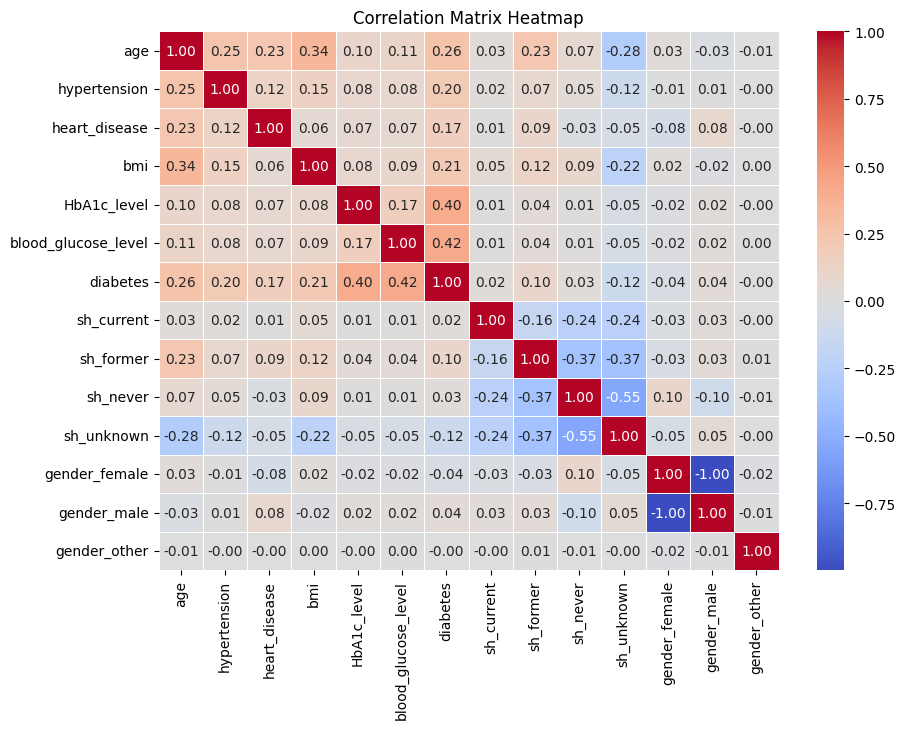

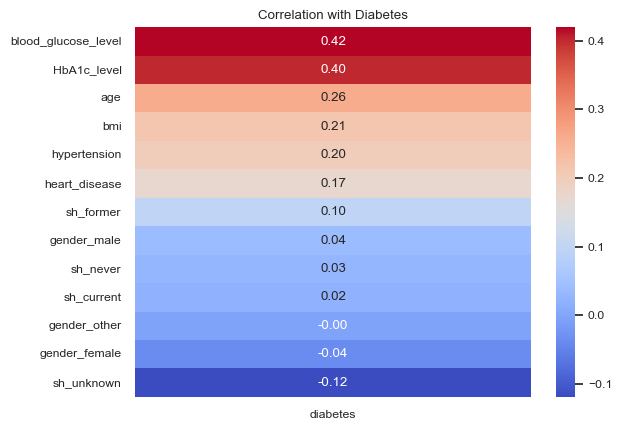

In [5]:
# Compute the correlation matrix
correlation_matrix = df.corr()
#Graph I.
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = df.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set_theme(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

In [6]:
# define the error metrics
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(tf.cast(y_true, tf.float32) * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(tf.cast(y_true, tf.float32), 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(tf.cast(y_true, tf.float32) * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

In [7]:
# setup the layers

regfac = 0.00002

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=l1(regfac))
    # tf.keras.layers.Dense(10, activation='relu'),
    # tf.keras.layers.Dense(2, activation='sigmoid')
])

epochs = 8

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[ 'accuracy', tf.keras.metrics.F1Score(average='macro'),])

In [8]:
class_weights = {0: 1., 1: 1.}
history = None
%time history = model.fit(X_train, y_train, epochs=epochs, verbose=1, validation_data=(X_cv, y_cv), class_weight=class_weights)
test_loss, test_acc, test_f1 = model.evaluate(X_test, y_test)

Epoch 1/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9208 - f1_score: 0.3283 - loss: 0.2023 - val_accuracy: 0.9616 - val_f1_score: 0.4002 - val_loss: 0.1131
Epoch 2/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.9629 - f1_score: 0.4007 - loss: 0.1086 - val_accuracy: 0.9635 - val_f1_score: 0.4045 - val_loss: 0.1047
Epoch 3/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.9648 - f1_score: 0.4065 - loss: 0.1040 - val_accuracy: 0.9661 - val_f1_score: 0.4139 - val_loss: 0.0988
Epoch 4/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - accuracy: 0.9668 - f1_score: 0.4130 - loss: 0.0993 - val_accuracy: 0.9675 - val_f1_score: 0.4170 - val_loss: 0.0950
Epoch 5/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 684us/step - accuracy: 0.9663 - f1_score: 0.4106 - loss: 0.0963 - val_accuracy: 0.9678 - val_f1_score: 0.4179 - val_loss: 0.0928
Epoch 6/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9674 - f1_score: 0.4162 - loss: 0.0939 - val_accuracy: 0.9683 - val_f1

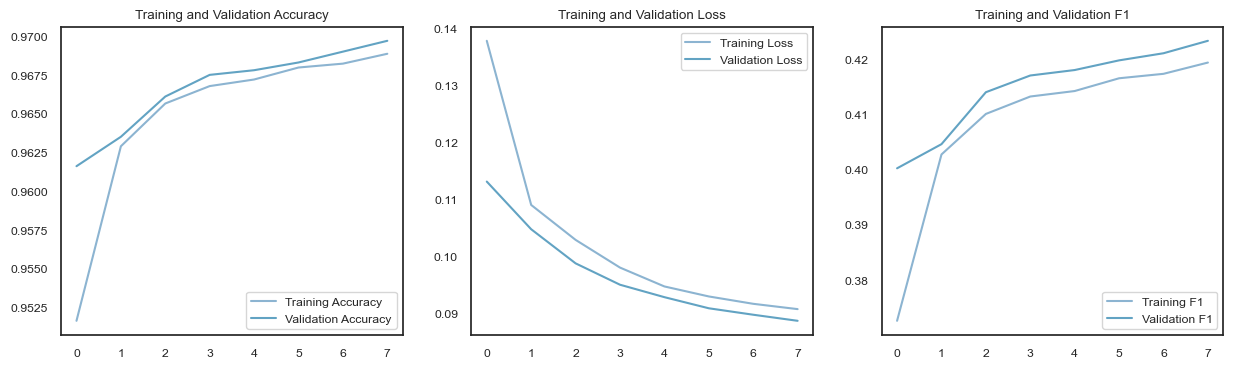

test acc: 96.78% test loss: 0.093 test f1: 0.414


In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

epochs_range = range(epochs)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, f1_score, label='Training F1')
plt.plot(epochs_range, val_f1_score, label='Validation F1')
plt.legend(loc='lower right')
plt.title('Training and Validation F1')

plt.show()

print(f'test acc: {test_acc*100:0.2f}% test loss: {test_loss:0.3f} test f1: {test_f1:0.3f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
              precision    recall  f1-score   support

     healthy       0.97      1.00      0.98      9155
    diabetes       0.98      0.63      0.77       845

    accuracy                           0.97     10000
   macro avg       0.97      0.81      0.88     10000
weighted avg       0.97      0.97      0.96     10000



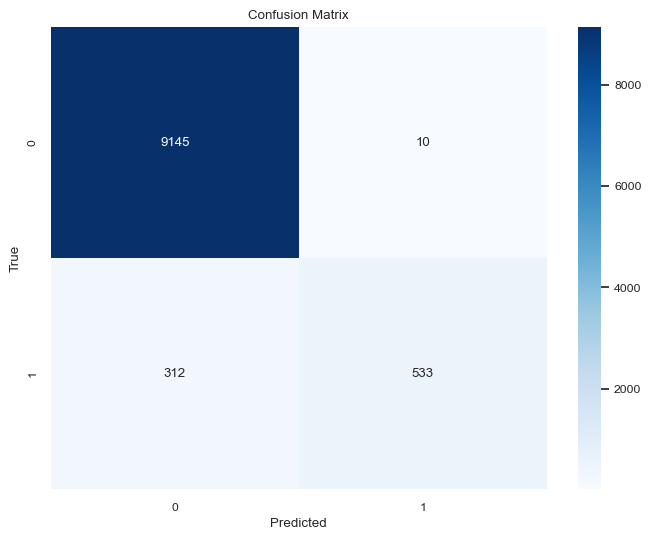

In [10]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Generate the classification report
print(classification_report(y_test, y_pred_classes, target_names=['healthy', 'diabetes']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()